# Read the CSV and get data out

In [15]:
import pandas as pd
df = pd.read_csv('./carmen_stats_node_distribution.csv')
# Remove all empty nodes
df = df[df['Node Type'] != 'Empty']
# Remove the duplicated entry where `Node Type` == `Node Subtype`
df = df[df['Node Type'] != df['Node Subtype']]
# Group by `Node Type` and calculate the prefix sum of `Node Count` within each group
grouped_df = df.groupby('Node Type').apply(lambda x: x.assign(PrefixSum=x['Node Count'].cumsum())).reset_index(drop=True)
# Collect the node info into a nested dictionary
node_info = dict()
for name, group in grouped_df.groupby('Node Type'):
    node_info[name] = dict()
    node_info[name]['total_count'] = group['Node Count'].sum()
    node_info[name]['subtype_count'] = dict()
    node_info[name]['prefix_sum'] = dict()
    for index, row in group.iterrows():
        id = int(row['Node Subtype'].strip(name + '_')) - 1
        node_info[name]['subtype_count'][id] = row['Node Count']
        node_info[name]['prefix_sum'][id] = row['PrefixSum']

/tmp/ipykernel_71051/2239498315.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = df.groupby('Node Type').apply(lambda x: x.assign(PrefixSum=x['Node Count'].cumsum())).reset_index(drop=True)


In [3]:
# Define the sizes of the nodes

commitment_size = 32
id_size = 6
id_index = 1
full_inner_node_size = commitment_size + 256 * id_size
sparse_inner_node_size = lambda num_children: commitment_size + num_children * (id_size + id_index)
inner_node_sizes = [sparse_inner_node_size(element + 1) for element in range(255)]
inner_node_sizes.append(full_inner_node_size)

value_size = 32
value_index = 1
full_leaf_node_size = commitment_size + 256 * value_size
sparse_leaf_node_size = lambda num_children: commitment_size + num_children * (value_size + value_index)
leaf_node_sizes = [sparse_leaf_node_size(element + 1) for element in range(255)]
leaf_node_sizes.append(full_leaf_node_size)

# Brute force approach 

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sortedcontainers import SortedSet, SortedDict
import itertools

def calculate_size(num_nodes_to_use, prefix_sum: dict, max_node: int, node_sizes: dict):
    assert num_nodes_to_use > 0

    # All combination of num-nodes - 1 indexes, with the biggest node always included
    available_nodes = [i for i in prefix_sum.keys() if i != max_node]
    initial_indexes = SortedSet() # The set of indexes of the selected node sizes
    initial_indexes.add(max_node) # always include the biggest node

    def calculate_size_for_indexes(index_combination):
        cur_indexes = initial_indexes.copy()
        cur_indexes.update(index_combination)
        space_occupied = 0
        already_covered_nodes = 0
        cur_solution = SortedDict()
        for value in cur_indexes:
            num_nodes_covered = prefix_sum[value] - already_covered_nodes
            space_occupied += node_sizes[value] * num_nodes_covered
            already_covered_nodes += num_nodes_covered
            cur_solution[value] = num_nodes_covered
        return cur_solution, space_occupied
    
    # Initial minimum solution to the worst case (only the biggest node)
    min_space_occupied = prefix_sum[max_node] * node_sizes[max_node]
    min_solution = SortedDict()
    min_solution[max_node] = prefix_sum[max_node]

    index_combinations = list(itertools.combinations(available_nodes, num_nodes_to_use - 1))
    max_concurrent = 100
    prev = 0 
    with ThreadPoolExecutor(max_workers=8) as executor:
        while prev < len(index_combinations):
            futures = []
            for i in range(prev, min(prev + max_concurrent, len(index_combinations))):
                futures.append(executor.submit(calculate_size_for_indexes, index_combinations[i]))
            for future in as_completed(futures):
                cur_solution, space_occupied = future.result()
                if space_occupied < min_space_occupied:
                    min_space_occupied = space_occupied
                    min_solution = cur_solution.copy()
            prev += max_concurrent
    return min_solution, min_space_occupied


# Greedy approach

In [5]:
from sortedcontainers import SortedSet, SortedDict
import sys

def solve_greedy(num_nodes_to_use, node_prefix_sum: dict, max_node: int, node_sizes: dict):
    assert num_nodes_to_use > 0

    # All combination of num-nodes - 1 indexes, with the biggest node always included
    available_nodes = [i for i in node_prefix_sum.keys() if i != max_node]
    initial_indexes = SortedSet() # The set of indexes of the selected node sizes
    initial_indexes.add(max_node) # always include the biggest node

    def calculate_size_for_indexes(indices):
        space_occupied = 0
        already_covered_nodes = 0
        cur_solution = SortedDict()
        for value in indices:
            num_nodes_covered = node_prefix_sum[value] - already_covered_nodes
            space_occupied += node_sizes[value] * num_nodes_covered
            already_covered_nodes += num_nodes_covered
            cur_solution[value] = num_nodes_covered
        return cur_solution, space_occupied
    
    # Initial minimum solution to the worst case (only the biggest node)
    min_size = node_prefix_sum[max_node] * node_sizes[max_node]
    min_solution = SortedDict()
    min_solution[max_node] = node_prefix_sum[max_node]

    while len(min_solution) < num_nodes_to_use:
        min_tmp_solution = min_solution.copy()
        min_tmp_size = sys.maxsize
        for candidate_key in available_nodes:
            if candidate_key in min_solution:
                continue
            current_indexes = SortedSet(min_solution.keys())
            current_indexes.add(candidate_key)
            current_solution, current_size = calculate_size_for_indexes(current_indexes)
            if current_size < min_tmp_size:
                min_tmp_size = current_size
                min_tmp_solution = current_solution
        min_solution = min_tmp_solution
        min_size = min_tmp_size

    solution = dict()
    for key in min_solution:
        solution[key + 1] = min_solution[key]
    return solution, min_size

# Mixed Integer Programming

In [ ]:
import os
from pulp import *

def solve_mip(num_nodes_to_use, node_count_by_type: dict, node_prefix_sum: dict, max_node: int, node_sizes: dict, greedy_solution: dict, node_pruning_threshold: float):
    greedy_dict, _ = greedy_solution
    total_node_count = max(node_prefix_sum.values())
    assert num_nodes_to_use > 0
 
    problem = LpProblem("Trie size problem", LpMinimize)
    nodes_range = [i for i in node_prefix_sum.keys()]
    # Upper bound is the prefix sum of each node type
    nodes_lp_variable = {
        i: LpVariable(f"n_{i}", lowBound=0, upBound=node_prefix_sum[i], cat=LpInteger)
        for i in nodes_range
    }
    # Use the greedy solution as initial solution
    for i in greedy_dict.keys():
        nodes_lp_variable[i - 1].setInitialValue(greedy_dict[i])
    # Setup linked binary variables
    node_exist_binary = LpVariable.dicts("n_binary", nodes_range, 0, 1, cat = 'Binary')
    # Objective function
    problem += lpSum([nodes_lp_variable[i] * node_sizes[i] for i in nodes_range]), "Minimize trie size"
    # Constraints
    # ## Sum of number of inner nodes must be equals to the total number of inner nodes
    problem += lpSum(nodes_lp_variable[i] for i in nodes_range) == total_node_count, "Must cover all nodes"
    # ## Exclude all variable with less than threshold% of the total number of nodes
    threshold_count = (node_pruning_threshold * total_node_count) / 100.0
    print("Pruning threshold count: ", threshold_count)
    for i in nodes_range:
        var_size = node_count_by_type[i]
        if var_size < threshold_count:
            problem += nodes_lp_variable[i] == 0
    # ## Must cover all nodes minus the one covered by previous nodes
    for i in nodes_range:
        problem += nodes_lp_variable[i] <= node_prefix_sum[i] - lpSum(nodes_lp_variable[j] for j in range(0, i) if j in nodes_range), f"node {i} cover at at least its node minus the one covered by the previous nodes"
    # ## Special case: biggest variable must cover the remaining nodes
    last_node_index = max(node_count_by_type.keys())
    problem += node_count_by_type[last_node_index] <= nodes_lp_variable[max_node], "Last node must cover remaining nodes"
    # ## Link the variables to the binary ones
    for i in nodes_range:
        problem += nodes_lp_variable[i] <= (node_prefix_sum[i] + 1) * node_exist_binary[i], f"Link variable {i} existence to usage"
    # ## Limit number of variables to use
    problem += lpSum([node_exist_binary[i] for i in nodes_range]) == num_nodes_to_use, "Limit number of variables to use"
    
    # Solve the problem
    solver = getSolver("SCIP_PY", msg=0, threads=os.cpu_count())
    problem.solve(solver)
    
    solution = dict()
    for j in nodes_range:
        if nodes_lp_variable[j].varValue>= 1:
            solution[j + 1] = nodes_lp_variable[j].varValue # every node is shifted by 1
    size = problem.objective.value()

    return solution, size

In [ ]:
def print_results(solution_type, solution, size, prev_solution_size, writer):
    writer.write(f"{solution_type} solution:\n")
    writer.write(f"    {len(solution)}: ")
    writer.write(f"{solution}\n")
    writer.write(f"       Size in MiB: {size / (1024 * 1024)}\n")
    if prev_solution_size != None:
        writer.write(f"       Saved space in MiB: {(prev_solution_size - size) / (1024 * 1024)}\n")
        writer.write(f"       Saved space in percentage: {100.0 * (prev_solution_size - size) / prev_solution_size}%\n")

/home/luigi-ph3/carmen/.venv/lib/python3.12/site-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/home/luigi-ph3/carmen/.venv/lib/python3.12/site-packages/pulp/apis/scip_api.py:631: UserWarning: The solver SCIP_PY can only run with a single thread
  warnings.warn(


Pruning threshold count:  0.0
Pruning threshold count:  0.0
Pruning threshold count:  0.0
Pruning threshold count:  0.0
Pruning threshold count:  0.0


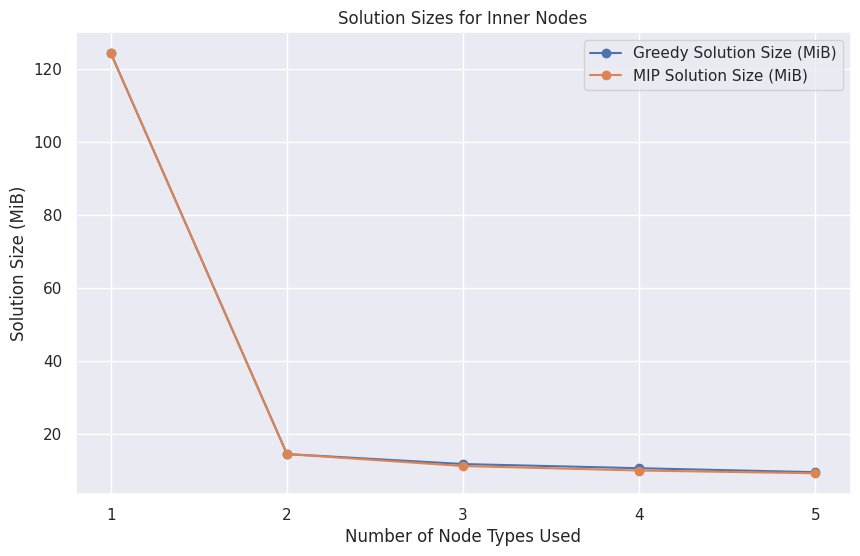

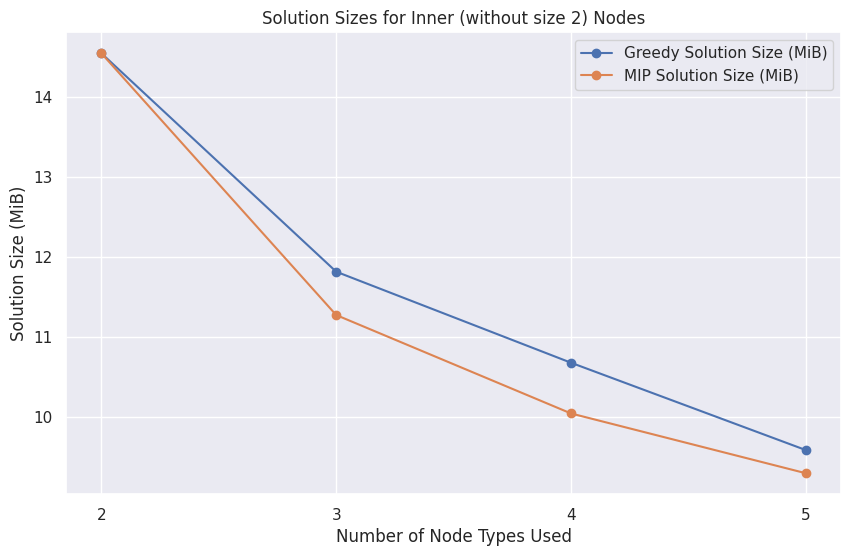

Pruning threshold count:  54.2395
Pruning threshold count:  54.2395
Pruning threshold count:  54.2395
Pruning threshold count:  54.2395
Pruning threshold count:  54.2395


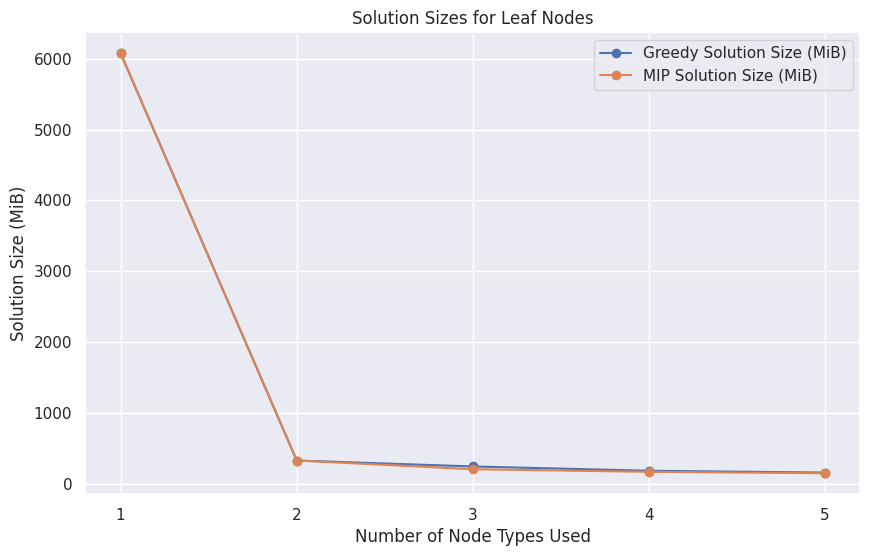

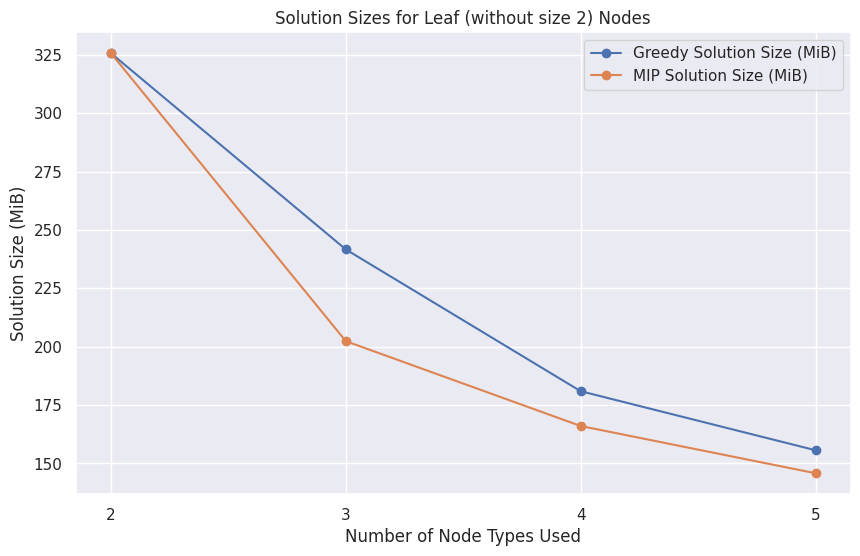

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_solution_sizes(node_name, node_range, solution_sizes_greedy, solution_sizes_mip):
        def _plot(node_name, node_range, solution_sizes_greedy, solution_sizes_mip):
                sns.set_theme()
                plt.figure(figsize=(10, 6))
                plt.plot(node_range, [size / (1024 * 1024) for size in solution_sizes_greedy], marker='o', label='Greedy Solution Size (MiB)')
                plt.plot(node_range, [size / (1024 * 1024) for size in solution_sizes_mip], marker='o', label='MIP Solution Size (MiB)')
                plt.title(f'Solution Sizes for {node_name} Nodes')
                plt.xlabel('Number of Node Types Used')
                plt.ylabel('Solution Size (MiB)')
                plt.xticks(node_range)
                plt.legend()
                plt.grid(True)
                plt.show()

        _plot(node_name, node_range, solution_sizes_greedy, solution_sizes_mip)
        # plot starting from position 1
        solution_sizes_greedy = solution_sizes_greedy[1:]
        solution_sizes_mip = solution_sizes_mip[1:]
        node_range = node_range[1:]
        _plot(node_name + " (without size 1)", node_range, solution_sizes_greedy, solution_sizes_mip)

def solve(node_name, node_range, node_info: dict, max_node: int, node_sizes: dict, node_pruning_threshold: float, writer):
        solution_sizes_greedy = []
        solution_sizes_mip = []
        # add max_node to the node_info if not present
        if max_node not in node_info['subtype_count']:
                node_info['subtype_count'][max_node] = 0
        if max_node not in node_info['prefix_sum']:
                node_info['prefix_sum'][max_node] = node_info['prefix_sum'][max(node_info['prefix_sum'].values())]

        writer.write("\n-------------------------------\n")
        writer.write(f"--------- {node_name} nodes ---------\n")
        prev_greedy_solution_size = None
        prev_ilp_solution_size = None
        for i in node_range:
                greedy_solution = solve_greedy(i, node_info['prefix_sum'], max_node, node_sizes)
                print_results("Greedy", greedy_solution[0], greedy_solution[1], prev_greedy_solution_size, writer)
                solution_sizes_greedy.append(greedy_solution[1])
                ilp_solution, ilp_size = solve_mip(i, node_info['subtype_count'], node_info['prefix_sum'], 255, node_sizes, greedy_solution, node_pruning_threshold)
                print_results("MIP", ilp_solution, ilp_size, prev_ilp_solution_size, writer)
                solution_sizes_mip.append(ilp_size)
                writer.write(f"Difference between Greedy and MIP: {(greedy_solution[1] - ilp_size) / (ilp_size) * 100}%\n")
                prev_greedy_solution_size = greedy_solution[1]
                prev_ilp_solution_size = ilp_size
        plot_solution_sizes(node_name, node_range, solution_sizes_greedy, solution_sizes_mip)
        writer.write("-------------------------------\n\n")

with open("node_optimization_results.txt", "w") as writer:
        solve("Inner", range(1,6), node_info['Inner'], 255, inner_node_sizes, 0, writer)
        solve("Leaf", range(1,6), node_info['Leaf'], 255, leaf_node_sizes, 0.007, writer)
        writer.flush()